# Tech Challenge Grupo 10

Para o tech challenge da fase 1 foi adotado o dataset:

Breast Cancer Wisconsin (Diagnostic) Data Set
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data

O modelo classificador utilizado aqui por se tratar de uma classificação binária foi a Regressão Logística

In [17]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, classification_report, confusion_matrix

## Carga dos dados
Durante a importação dos dados foi percebido o seguinte:
- existem muitas derivadas, com o -se (standard error)
- o marcador de identificação da presença de câncer é a coluna "diagnosis", porém é um campo str e precisa ser adaptado
- o arquivo de entrada tem uma vírgula no final que adiciona uma coluna de maneira errada, então ela foi removida
- não existem dados nulos
- nome da coluna "concave points_mean" está bem diferente do padrão

In [18]:
df = pl.read_csv("../data/data.csv")
df.describe()

statistic,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",569.0,"""569""",569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,"""0"""
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""569"""
"""mean""",3.0372e7,null,14.127292,19.289649,91.969033,654.889104,0.09636,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.26919,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,null
"""std""",1.2502e8,null,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.07972,0.038803,0.027414,0.00706,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.00617,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,null
"""min""",8670.0,"""B""",6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,0.04996,0.1115,0.3602,0.757,6.802,0.001713,0.002252,0.0,0.0,0.007882,0.0008948,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504,null
"""25%""",869218.0,null,11.7,16.17,75.17,420.3,0.08637,0.06492,0.02956,0.02031,0.1619,0.0577,0.2324,0.8339,1.606,17.85,0.005169,0.01308,0.01509,0.007638,0.01516,0.002248,13.01,21.08,84.11,515.3,0.1166,0.1472,0.1145,0.06493,0.2504,0.07146,null
"""50%""",906024.0,null,13.37,18.84,86.24,551.1,0.09587,0.09263,0.06154,0.0335,0.1792,0.06154,0.3242,1.108,2.287,24.53,0.00638,0.02045,0.02589,0.01093,0.01873,0.003187,14.97,25.41,97.66,686.5,0.1313,0.2119,0.2267,0.09993,0.2822,0.08004,null
"""75%""",8.813129e6,null,15.78,21.8,104.1,782.7,0.1053,0.1304,0.1307,0.074,0.1957,0.06612,0.4789,1.474,3.357,45.19,0.008146,0.03245,0.04205,0.01471,0.02348,0.004558,18.79,29.72,125.4,1084.0,0.146,0.3391,0.3829,0.1614,0.3179,0.09208,null
"""max""",9.11320502e8,"""M""",28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,0.2012,0.304,0.09744,2.873,4.885,21.98,542.2,0.03113,0.1354,0.396,0.05279,0.07895,0.02984,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075,null


## Adequação dos dados
Remoção da coluna vazia no final

Mudança do nome da coluna "concave points_mean" para "concave_points_mean" mantendo o padrão de nomenclatura

Conversão do único dado em formato literal, e adição adjacente a coluna que o representa para facilitar a identificação, pelos testes:
- 'M' foi convertido para 1
- 'B' foi convertido para 0

In [19]:
df = df.drop(df.columns[-1])

df = df.rename({"concave points_mean":"concave_points_mean"})

labelEncoder = LabelEncoder()
adequated_diagnosis = pl.Series("diagnosis_int",labelEncoder.fit_transform(df.select('diagnosis')))
df.insert_column(2, adequated_diagnosis)

/home/hipolito/Developer/fiap-pos-ai4devs-2025/tech-challenge-grupo-10/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


id,diagnosis,diagnosis_int,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
842302,"""M""",1,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,"""M""",1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,"""M""",1,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,"""M""",1,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,"""M""",1,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
926424,"""M""",1,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623,1.176,1.256,7.673,158.7,0.0103,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
926682,"""M""",1,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.0395,0.01678,0.01898,0.002498,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
926954,"""M""",1,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.0473,0.01557,0.01318,0.003892,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782


## Remoção de outliers
Quando há análise da presença de outliers, segue a análise do boxplot que permite ver uma presença de outliers dentro da massa de dados presentes em todas as colunas de média.

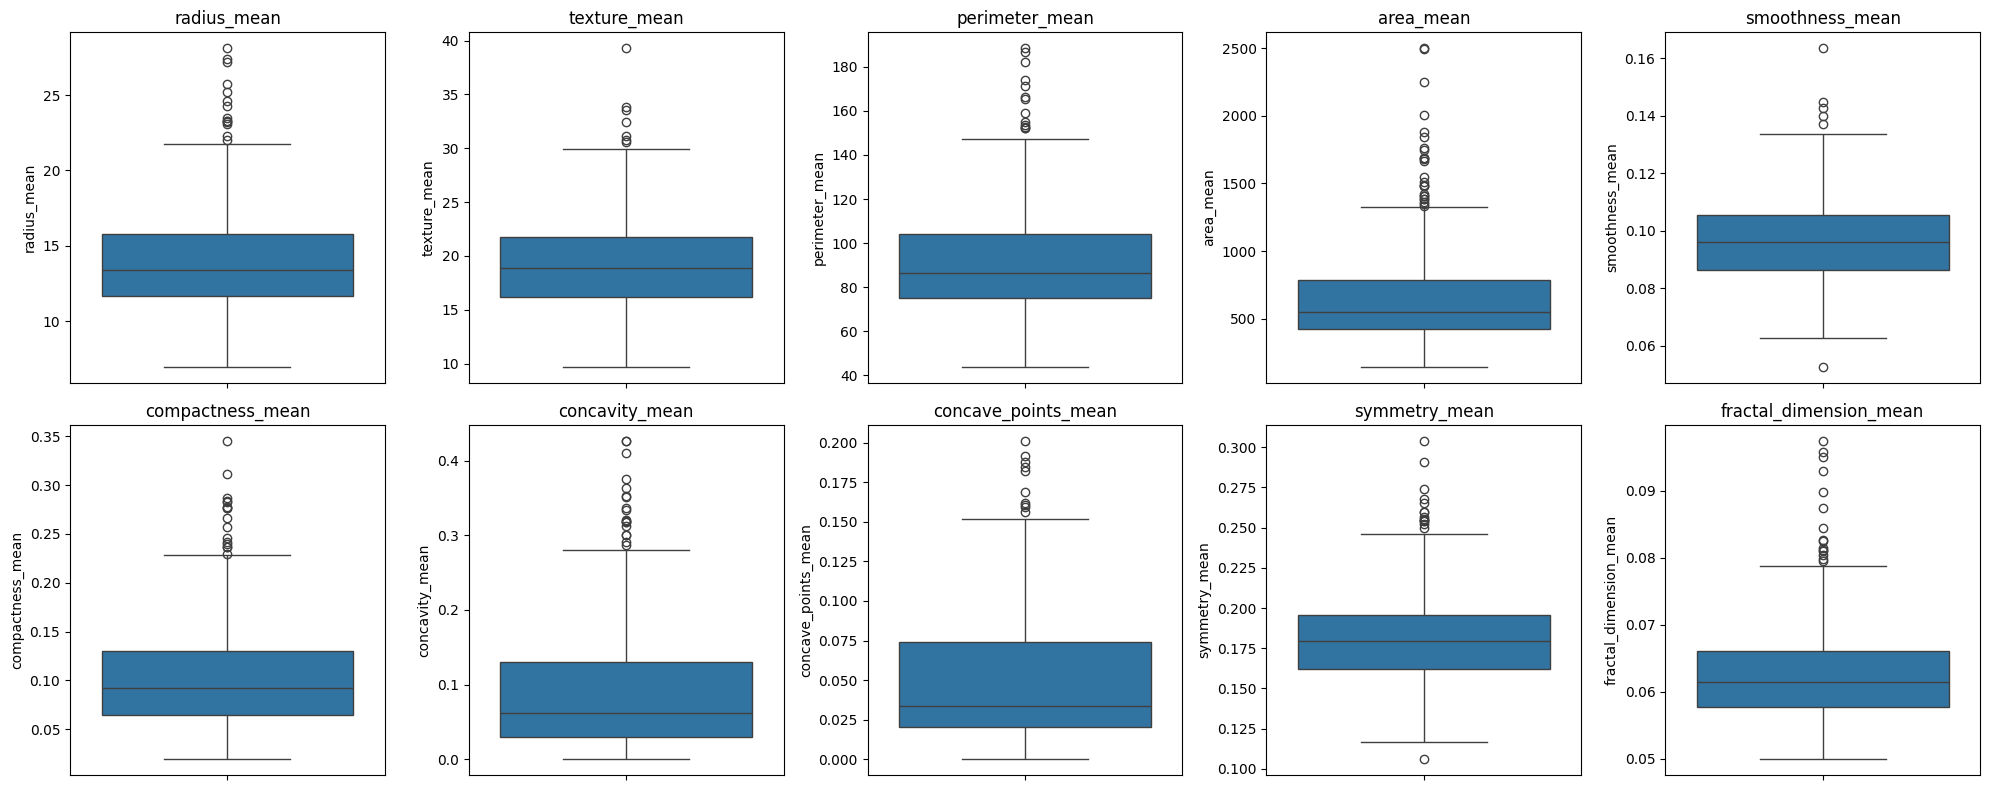

In [20]:
selected_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave_points_mean", "symmetry_mean", "fractal_dimension_mean"
]

# Criar figura com 2 linhas e 5 colunas de subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()  # transforma em lista para iterar

df_pandas = df.to_pandas()  # converte para pandas

# Criar um boxplot em cada subplot
for i, feature in enumerate(selected_features):
    sns.boxplot(y=df_pandas[feature], ax=axes[i])
    axes[i].set_title(feature)

# Ajusta layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Checar a correlação entre as variáveis

#### Heatmap
Usando a correlação e o mapa de calor (heatmap) existe um relacionamento significativo entre o diagnóstico ("diagnosis") e:
- radius_mean: 0.73
- perimeter_mean: 0.74
- area_mean: 0.71
- concavity_mean: 0.7
- concave_points_mean: 0.78

<Axes: >

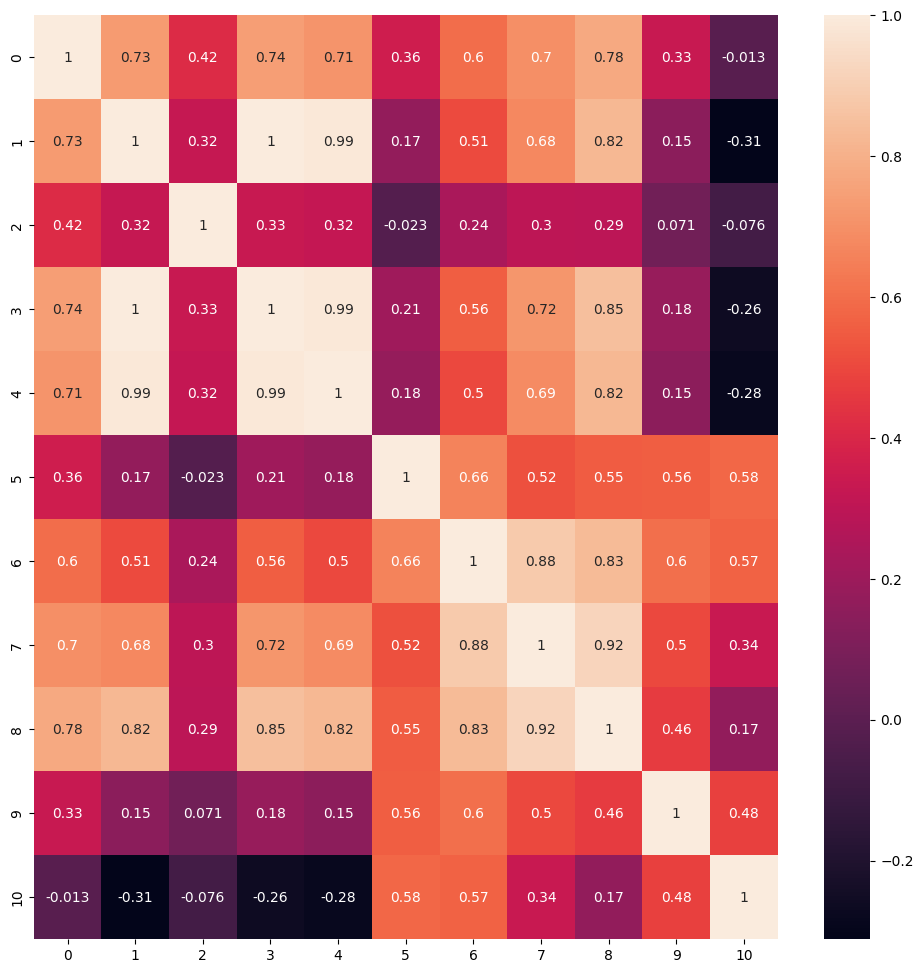

In [ ]:
df_cut = df["diagnosis_int","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean"]
correlation = df_cut.corr()
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(correlation, annot=True, ax=ax)

#### Pairplot
Porém ao analisar apenas pelas suas correlações com o diagnóstico, ficou evidente um certo equilibrio entre o grupo de variáveis, foi decidido o uso de um pairplot para realizar uma análise exploratória da correlação das variáveis para separar as categorias, e o cenário do mapa de calor se reflete em distribuições parecidas na correlação das variáveis.

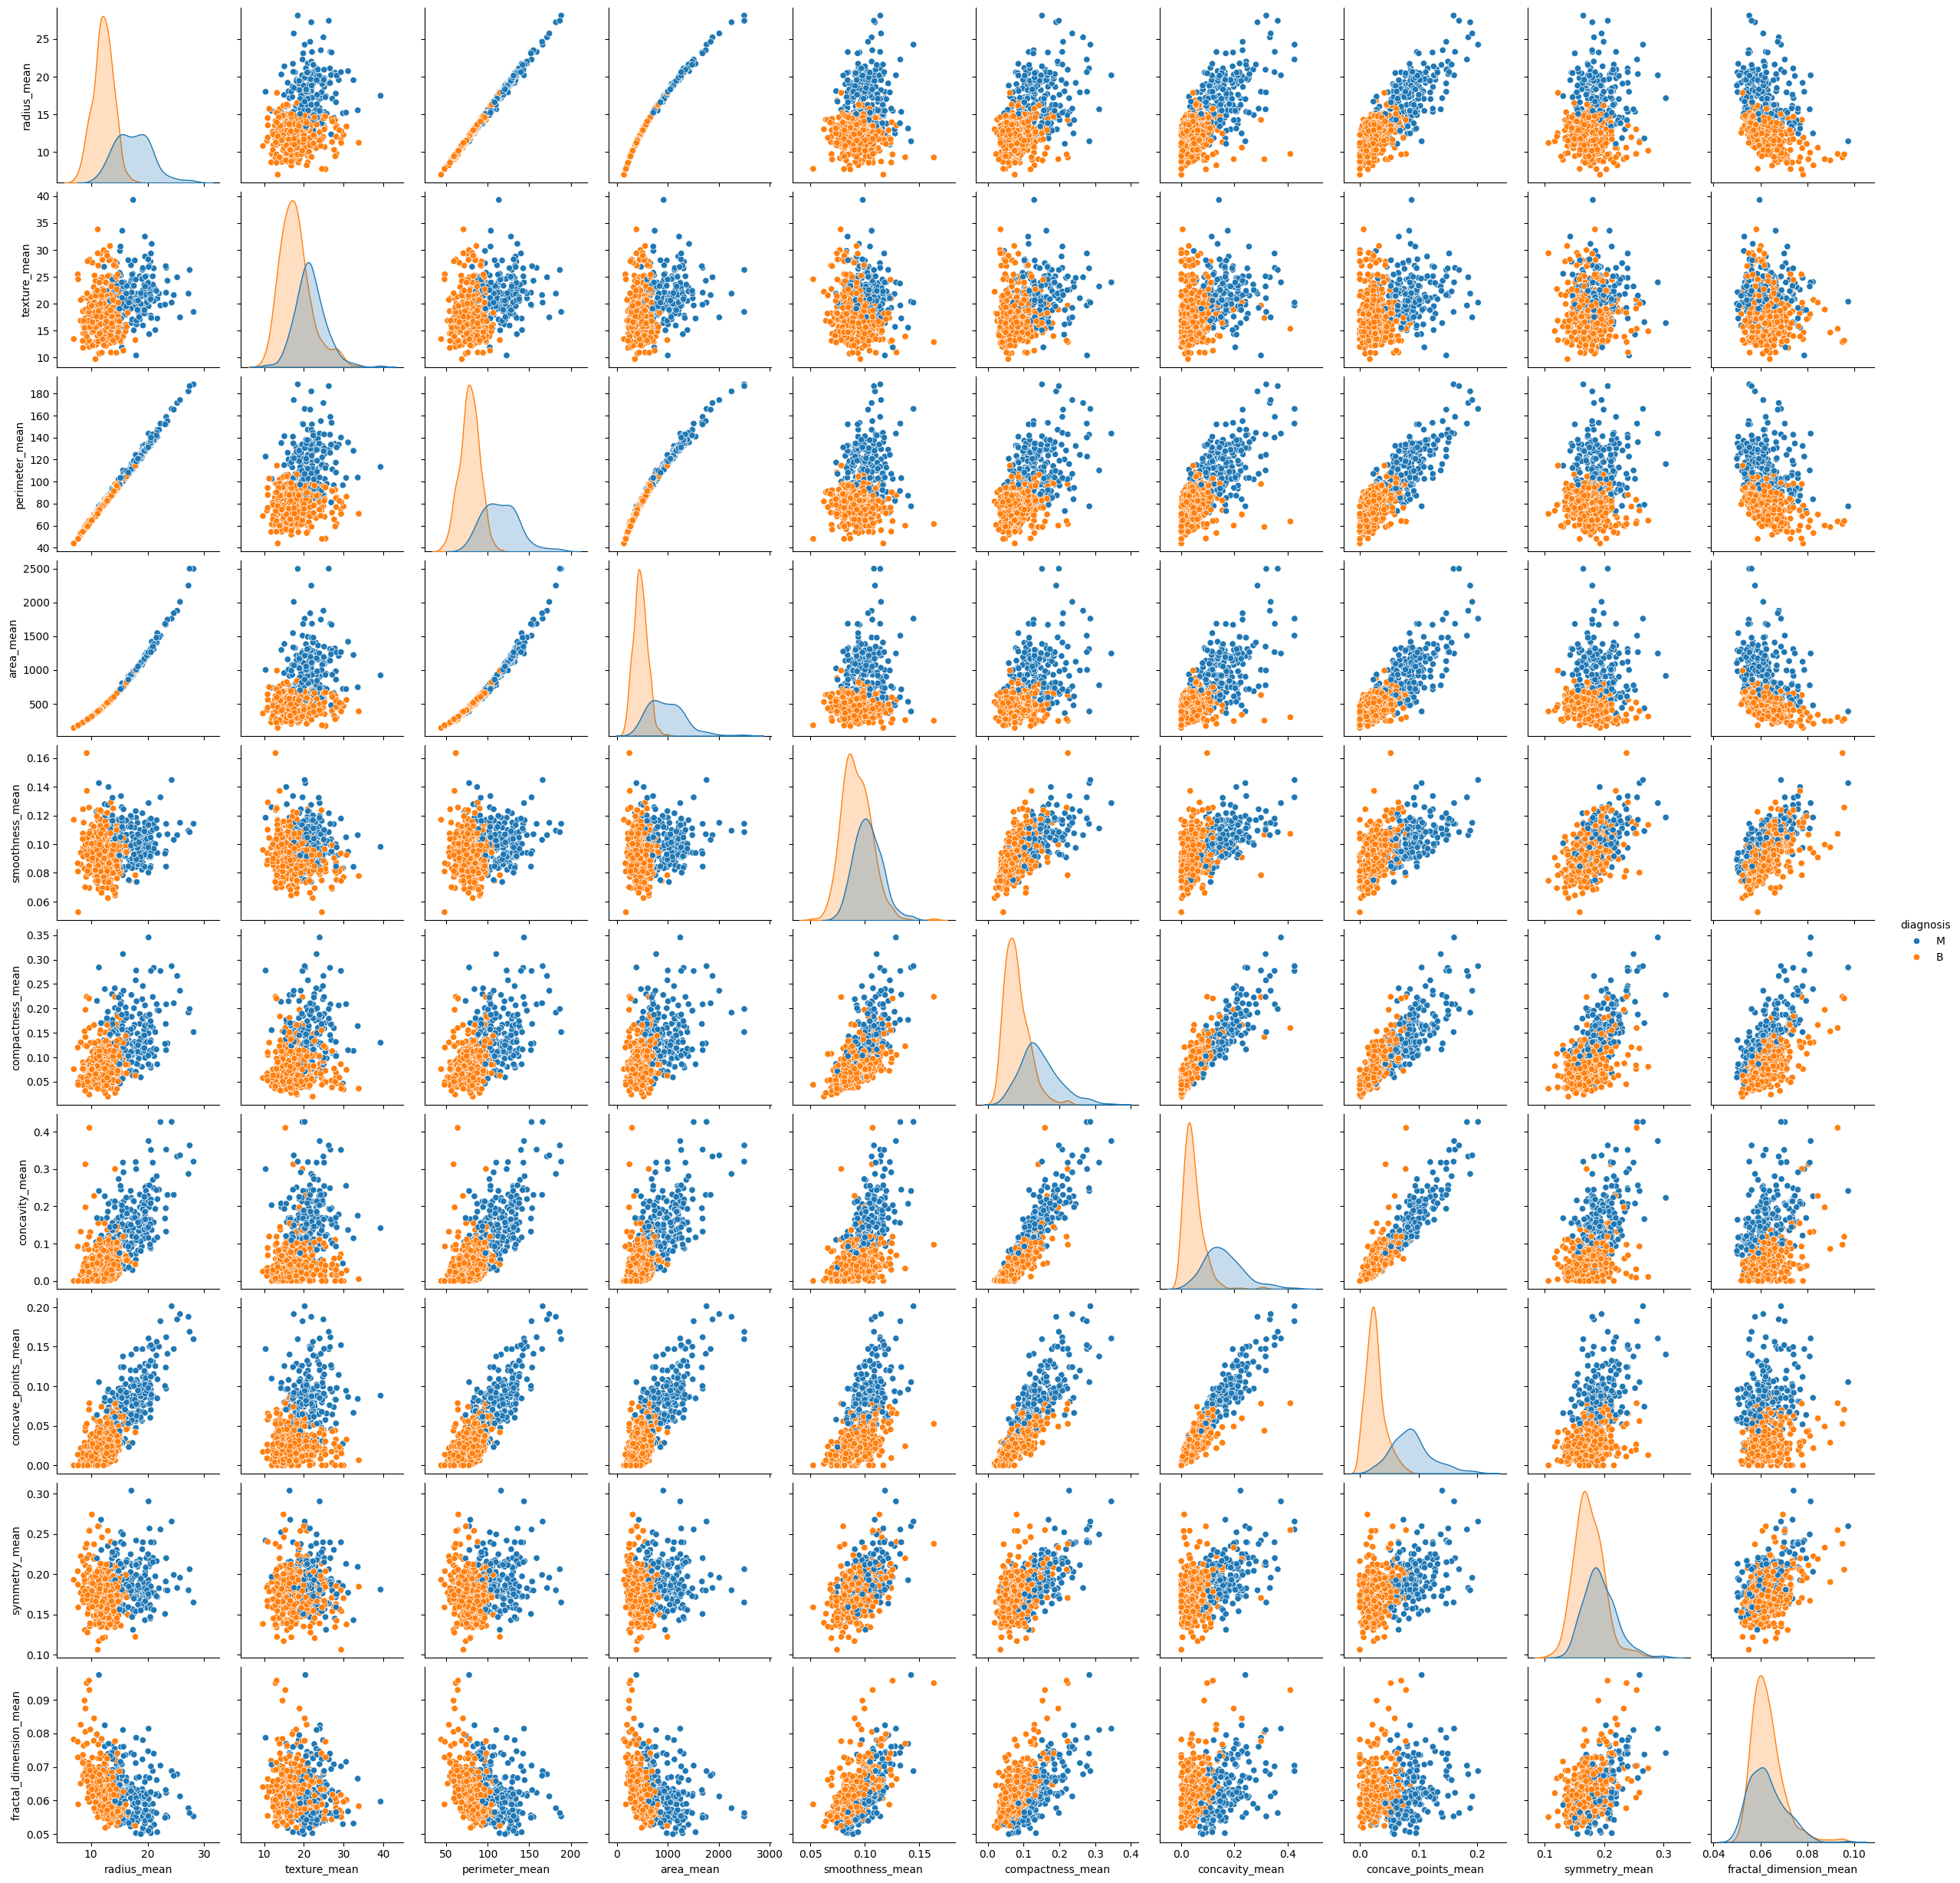

In [22]:
sns.pairplot(df.to_pandas(),vars=["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean"],hue="diagnosis")

## Separação dos dados para o treino do classificador
Remoção de outliers

Separar os dados para o treino do classificador sendo a coluna alvo e seus identificadores (diagnóstico), os valores de y correspondem a:
- id (necessário apenas para identificar o paciente do diagnósitco)
- diagnosis (alvo da predição, porém está como literal, mantido para conferência)
- diagnosis_int (alvo da predição convertido em inteiro para a execução dos passos de correlação)

As colunas analisadas previamente para a classificação foram mantidas:
- "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean"

Massa de testes definida em 0.2 e random_state=42

In [23]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
 
    return df.filter((df[column] >= lower_bound) & (df[column] <= upper_bound))

In [24]:
df_out = df

for column in ["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean"]:
    df_out = remove_outliers_iqr(df_out, column)

y = df_out["id", "diagnosis", "diagnosis_int"]
X = df_out["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean"]

X_train, X_test, y_train, y_test = train_test_split(X, y.get_column("diagnosis_int"), test_size=0.2, random_state=42)

## Treinamento do classificador
Para o treinamento do classificador foi utilizado o modelo de Regressão Linear, por sua simplicidade e foco na classificação binária

Inicialmente para a redução da escala foi adotado o StandardScaler, porém após análise comparativa do resultado da precisão, o MinMaxScaler foi selecionado para apresentar um resultado, mesmo que pequeno, foi superior.

Para a comparação do modelo foram adotadas as seguintes métricas:
- Accuracy: 0.95 (um bom resultado)
- Comparação com outro classificador baseado nas métricas de erro(MAE, MSE, MAPE, R2): Random Forest e Regressão Linear
- Classification Report (precision, recall, f1-score): onde os resultados demonstram uma boa taxa de acerto

In [25]:
rlog_model = make_pipeline(MinMaxScaler(), LogisticRegression(), memory=None)
rlog_model.fit(X_train, y_train)

y_pred_rlog = rlog_model.predict(X_test)
rlog_model.score(X_test, y_test)

0.9456521739130435

In [26]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_rlog)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


In [27]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_rlog)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_rlog)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, y_pred_rlog)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred_rlog)
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.05434782608695652
Mean Squared Error (MSE): 0.05434782608695652
Mean Absolute Percentage Error (MAPE): 48952169862722.83
R-squared (R2): 0.6805555555555556


In [28]:
rf_model = make_pipeline(MinMaxScaler(), RandomForestRegressor(n_estimators=100, random_state=42, criterion='absolute_error'), memory=None)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_model.score(X_test, y_test)

0.6400244444444444

In [29]:
# Calculate evaluation metrics for the RandomForest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest Mean Absolute Error (MAE): {mae_rf}")

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error (MSE): {mse_rf}")

mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Random Forest Mean Absolute Percentage Error (MAPE): {mape_rf}")

r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R-squared (R2): {r2_rf}")


Random Forest Mean Absolute Error (MAE): 0.14239130434782607
Random Forest Mean Squared Error (MSE): 0.061243478260869566
Random Forest Mean Absolute Percentage Error (MAPE): 463087526901357.56
Random Forest R-squared (R2): 0.6400244444444444


In [30]:
lr_model = make_pipeline(MinMaxScaler(), LinearRegression(), memory=None)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_model.score(X_test, y_test)

0.6486251940372758

In [31]:
# Calculate evaluation metrics for the Linear Regression model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Absolute Error (MAE): {mae_lr}")

mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error (MSE): {mse_lr}")

mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Absolute Percentage Error (MAPE): {mape_lr}")

r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared (R2): {r2_lr}")

Linear Regression Mean Absolute Error (MAE): 0.1800238557165647
Linear Regression Mean Squared Error (MSE): 0.059780212734678956
Linear Regression Mean Absolute Percentage Error (MAPE): 477367712326154.4
Linear Regression R-squared (R2): 0.6486251940372758


In [32]:
# Classification Report
print(classification_report(y_test, y_pred_rlog))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.94      0.80      0.86        20

    accuracy                           0.95        92
   macro avg       0.94      0.89      0.92        92
weighted avg       0.95      0.95      0.94        92



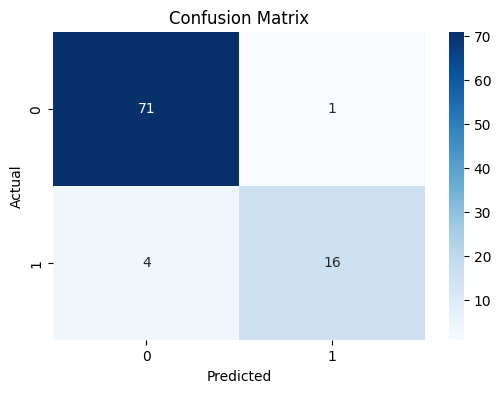

In [33]:
# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rlog)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Considerações finais
A respeito dos resultados, observado o valor de 95% de taxa de acerto médio do classificador, o tipo de dado utilizado sendo baseado em valores médios é uma aproximação generalista do que realmente pode ser a presença de câncer de mama numa paciente, ao ponto que este modelo pode ser usado pelo médico como uma ferramente de suporte para reforçar uma tomada de decisão sobre qual os próximos passos para dar um diagnóstico definitivo.